```
提取R语言中进行过特征选择的文件：train_SHAP.csv & test_SHAP.csv
getwd()
setwd(path_files[3])
# Step 1: Read the full dataset
train_data <- read.csv("train_normalized.csv")
test_data <- read.csv("test_normalized.csv")

# Step 2: Create a vector with the names of the selected features and the label
selected_features <- c("label", "original_shape_Elongation", "original_glcm_ClusterProminence",
                       "original_ngtdm_Complexity", "original_ngtdm_Strength",
                       "original_gldm_DependenceEntropy", "original_firstorder_Minimum",
                       "original_firstorder_Median")

# Step 3: Subset the dataframe
train_selected_data <- train_data[, selected_features]
test_selected_data <- test_data[, selected_features]

# Step 4: Write the new dataframe to a CSV file
write.csv(train_selected_data, "train_SHAP.csv", row.names = FALSE)
write.csv(test_selected_data, "test_SHAP.csv", row.names = FALSE)
```


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

"""
matplotlib.use('Agg')
设置一个无显示功能的后端;
若想在IDE中检查图像，请注释这条代码,并执行plt.show()；
若要保存图像，取消注释。
"""
matplotlib.use('Agg')  


from sklearn.svm import SVC
from sklearn.feature_selection import f_classif
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')


# print the JS visualization code to the notebook
import shap
shap.initjs()

seed = 15

In [2]:
# 设置工作目录及文件夹
os.chdir("D:/projects")

try:
  os.mkdir("D:/projects/SHAP_result_1")         # change this path if necessary
except FileExistsError:
  print("result directory already exist. OK to continue")

try:
  os.mkdir("D:/projects/SHAP_data_1")         # change this path if necessary
except FileExistsError:
  print("data directory already exist. OK to continue")

os.chdir("D:/projects/SHAP_result_1")

result directory already exist. OK to continue
data directory already exist. OK to continue


```
****将R中提取的train_SHAP.csv 与 test_SHAP.csv 文件放入SHAP_data_1文件夹；****
```

In [3]:
# 加载数据
train_data = pd.read_csv("../SHAP_data_1/train_SHAP.csv")
test_data = pd.read_csv("../SHAP_data_1/test_SHAP.csv")

# 分离特征和标签
x_train = train_data.drop('label', axis=1)
y_train = train_data['label']
x_test = test_data.drop('label', axis=1)
y_test = test_data['label']

In [4]:
# 检查列名是否正确
print(x_train.columns)
print(x_test.columns)

Index(['original_shape_Elongation', 'original_glcm_ClusterProminence',
       'original_ngtdm_Complexity', 'original_ngtdm_Strength',
       'original_gldm_DependenceEntropy', 'original_firstorder_Minimum',
       'original_firstorder_Median'],
      dtype='object')
Index(['original_shape_Elongation', 'original_glcm_ClusterProminence',
       'original_ngtdm_Complexity', 'original_ngtdm_Strength',
       'original_gldm_DependenceEntropy', 'original_firstorder_Minimum',
       'original_firstorder_Median'],
      dtype='object')


## <font color=darkblue>特征相关性热图</font>

In [5]:
# 提取x_train列名
cont = x_train.columns.tolist()
# cont = ['original_shape_Elongation', 'original_glcm_ClusterProminence','original_ngtdm_Complexity',
#         'original_ngtdm_Strength','original_gldm_DependenceEntropy','original_firstorder_Minimum','original_firstorder_Median']

# 计算特征相关性矩阵
corr_matrix = pd.DataFrame(train_data[cont],columns=cont).corr()

# 绘制热图
plt.figure(figsize=(10, 8))  # 可以调整图形的大小
sns.heatmap(corr_matrix,
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt='.2f')

# 调整布局
plt.tight_layout()

# 保存为图片
plt.savefig('1.feature_correlation_heatmap.pdf')

# # notebook中检查文件，使用PyCharm注释此行
# plt.show()

plt.close()  # 关闭图形，释放内存

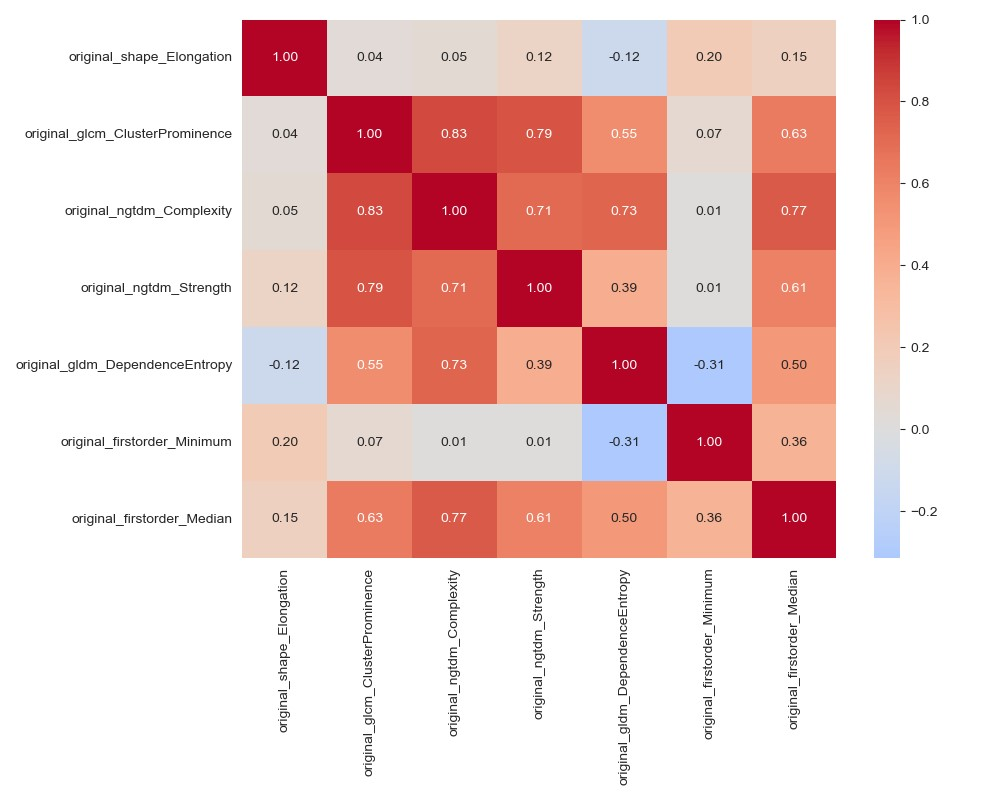

In [6]:
# 对label进行编码

y_train_encoded = np.where(y_train == 'Low', 0, 1)
y_test_encoded = np.where(y_test == 'Low', 0, 1)
print("Encoded labels for training set:", y_train_encoded)
print("Encoded labels for testing set:", y_test_encoded)

Encoded labels for training set: [0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0 1 1 1 0 0
 0 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 1 0]
Encoded labels for testing set: [0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 0]


In [7]:
# # 设置SVM参数网格
# param_grid = {
#     'C': 2 ** (np.arange(1.0, 8.0) - 4),
#     'class_weight': [None, 'balanced'] + [{0: 1, 1: w} for w in range(1, 6)]
# }

param_grid = {
    'C': 2 ** np.linspace(-3, 4, num=20),  # 更细的间隔
    'class_weight': [None, 'balanced'] + [{0: 1, 1: w} for w in np.linspace(1, 10, num=10)]  # 更细的权重配置
}

# 创建 SVM 模型
svm = SVC(kernel='linear', random_state=seed, probability=True)

# 定义自定义的 AUC 评分函数
def custom_auc(ground_truth, predictions):
    # 检查预测结果的形状
    if predictions.ndim == 1:
        # 如果是一维数组，直接使用
        proba = predictions
    else:
        # 如果是二维数组，使用第二列（正类的概率）
        proba = predictions[:, 1]
    return roc_auc_score(ground_truth, proba)

auc_scorer = make_scorer(custom_auc, needs_proba=True)

# 进行5折交叉验证
scores = cross_val_score(svm, x_train, y_train_encoded, cv=5, scoring=auc_scorer)

print("AUC分数: ", scores)
print("平均AUC分数: ", scores.mean())

svm.fit(x_train, y_train_encoded)

AUC分数:  [0.75555556 0.71111111 0.77777778 0.6        0.72222222]
平均AUC分数:  0.7133333333333334


SVC(kernel='linear', probability=True, random_state=15)

In [8]:
# 创建PCA对象，设置投影到2维
pca = PCA(n_components=2)

# 对特征数据进行降维处理
x_train_pca = pca.fit_transform(x_train)

# 可以在降维后的数据上重新训练SVM模型，也可以只是为了可视化而降维
svm_pca = SVC(kernel='linear', random_state=seed, probability=True)  # 确保可以计算概率
svm_pca.fit(x_train_pca, y_train_encoded)

# 创建网格以绘制决策边界
X1, X2 = np.meshgrid(np.linspace(x_train_pca[:, 0].min(), x_train_pca[:, 0].max(), num=400),
                     np.linspace(x_train_pca[:, 1].min(), x_train_pca[:, 1].max(), num=400))
grid = np.c_[X1.ravel(), X2.ravel()]
probs = svm_pca.predict_proba(grid)[:, 1].reshape(X1.shape)

# 绘制决策边界和数据点
plt.contourf(X1, X2, probs, alpha=0.7, cmap='coolwarm')
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train_encoded, cmap='coolwarm', edgecolors='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision boundary in PCA-transformed 2D space')
plt.colorbar()
# plt.show()

plt.tight_layout()

# 保存为图片
plt.savefig('2.PCA.pdf')
# plt.show()
plt.close()  # 关闭图形，释放内存

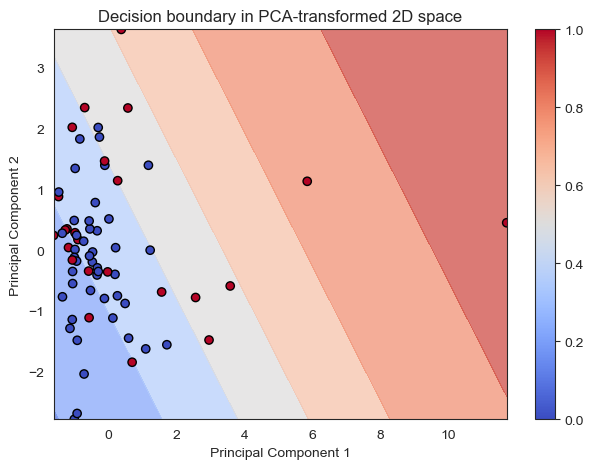

<font color=red>解读</font>

* 训练模型的数据存在一定的类不平衡问题,建议采用过采样或欠采样进行调整;

## <font color=darkblue>特征重要性 F-score 图</font>

In [9]:
# 计算特征的F-score和p-value
f_scores, p_values = f_classif(x_train, y_train_encoded)

indices = np.argsort(f_scores)[::-1]  # 从大到小排序特征索引
sorted_scores = f_scores[indices]
sorted_features = np.array(x_train.columns)[indices]

# palette: Blues, BuGn, GnBu, cubehelix, rocket, mako
plt.figure(figsize=(10, 6))
sns.set_style("white")
ax = sns.barplot(x=sorted_scores, y=sorted_features, palette="rocket", alpha = 0.7)
ax.set_xlabel('F-score')
ax.set_ylabel('Features')

# 设置坐标轴颜色
ax.spines['bottom'].set_color('black') # 设置x轴颜色
ax.spines['left'].set_color('black') # 设置y轴颜色

# 设置坐标轴刻度颜色
ax.tick_params(axis='x', colors='black') # 设置x轴刻度颜色
ax.tick_params(axis='y', colors='black') # 设置y轴刻度颜色

# 设置坐标轴标题颜色
ax.set_xlabel('F-score', color='black')
ax.set_ylabel('Features', color='black')

# for i in ax.patches:
#     ax.text(i.get_width()+0.2, i.get_y()+0.5, 
#             str(round((i.get_width()), 2)),
#             fontsize=10, color='grey')

plt.tight_layout()

# 保存为图片
plt.savefig('3.feature_importance_F-score.pdf')
# plt.show()
plt.close()  # 关闭图形，释放内存

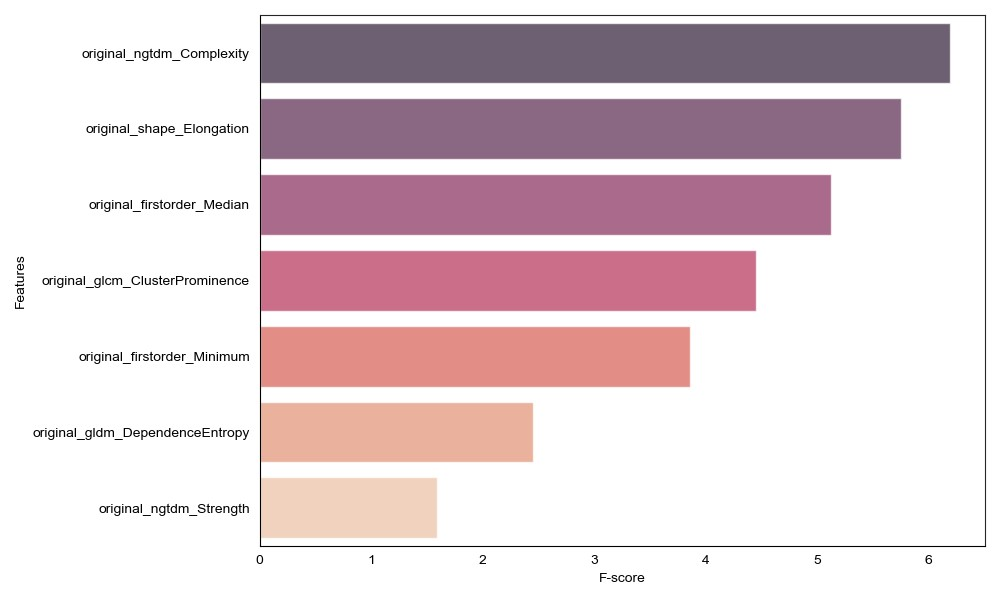

In [10]:
# 定义一个通用函数封装 predict_proba 方法
def svm_predict_proba(X):
    return svm.predict_proba(X)[:, 1]

# 使用同一函数获取训练集和测试集的正类预测概率
train_prob = svm_predict_proba(x_train)
test_prob = svm_predict_proba(x_test)

In [11]:
# 找到最大预测概率及其索引
max_value = max(train_prob)
max_index = train_prob.tolist().index(max_value)

# 打印最大预测概率及其索引
print("最大预测概率为:", max_value)
print("最大预测概率的索引为:", max_index)

最大预测概率为: 0.9945507957612045
最大预测概率的索引为: 65


In [12]:
# SHAP KernelExplainer 需要传入一个函数（这里是 svm_predict_proba），以及一个背景数据集（这里是 x_train）
explainer = shap.KernelExplainer(svm_predict_proba, x_train)

In [13]:
# 以SHAP的Explanation对象形式输出SHAP值
shap_values = explainer(x_train)

  0%|          | 0/69 [00:00<?, ?it/s]

In [14]:
# 换取解释器对象的预期值
expected_value = explainer.expected_value

# 一、全局预测值

## <font color=darkblue>全局条形图</font>
```
将 SHAP 值矩阵传递给条形图函数会创建一个全局特征重要性图，
其中每个特征的全局重要性通过计算该特征在所有给定样本SHAP_values的平均绝对值得到
```

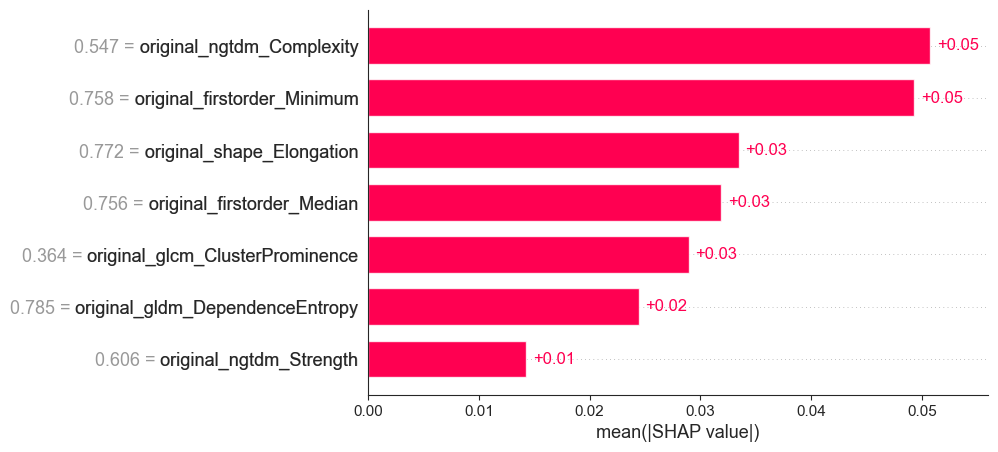

In [15]:
shap.plots.bar(shap_values, show_data=True)  # show_data=False
plt.tight_layout()
plt.savefig('4.global_summary_plot.pdf')
plt.close()

## <font color=darkblue>SHAP_values 局部条形图</font>
```
将一行 SHAP 值传递给条形图函数会创建局部特征重要性图，其中条形是每个特征的 SHAP 值。
仅评价单一样本特征的贡献度，一般用力图代替。

```

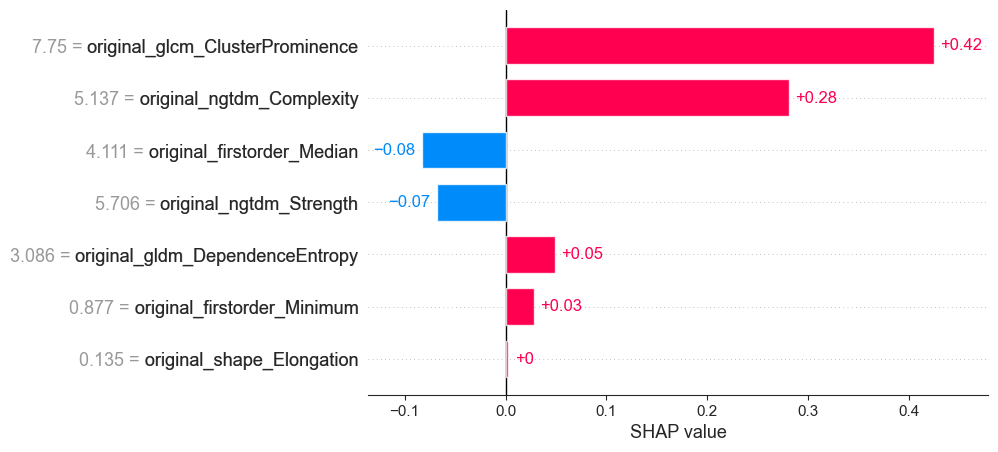

In [16]:
shap.plots.bar(shap_values[65],show_data=True) # shap_values[n]
plt.tight_layout()
plt.savefig('5.local_summary_plot.pdf', bbox_inches='tight', dpi=300)
plt.close()

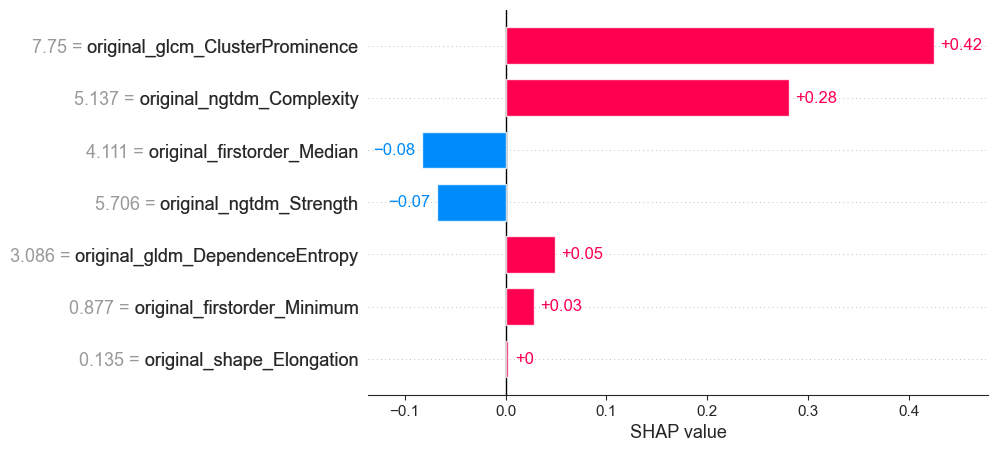

<font color=red>解读</font>

* 单一样本的特征贡献度,但是由于模型对正类的预测效果实在是太差了,所以在本例中很难参考;

## <font color=darkblue>SHAP_values 队列条形图</font>
```
为不同群组创建显示全局重要性的分组条形图。
```

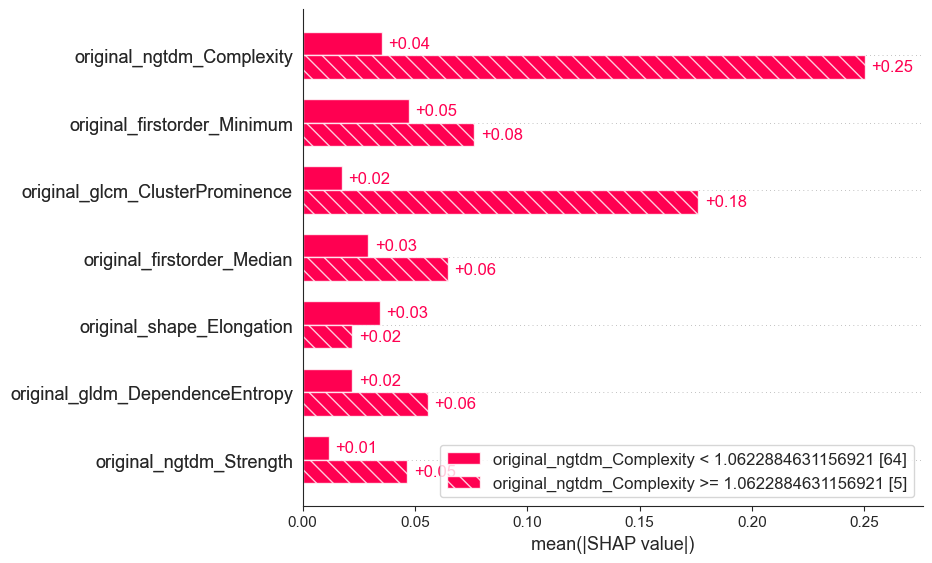

In [17]:
# abs计算每个SHAP值的绝对值。绝对值用于衡量影响的大小，而不考虑影响的方向（正面或负面影响）
# 对所有样本的每个特征向下计算平均值
shap.plots.bar(shap_values.cohorts(2).abs.mean(0))
plt.tight_layout()
# 如果需要，可以进一步调整子图间距
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.savefig('6.cohort_bar_plot.pdf', bbox_inches='tight', dpi=300)
plt.close()

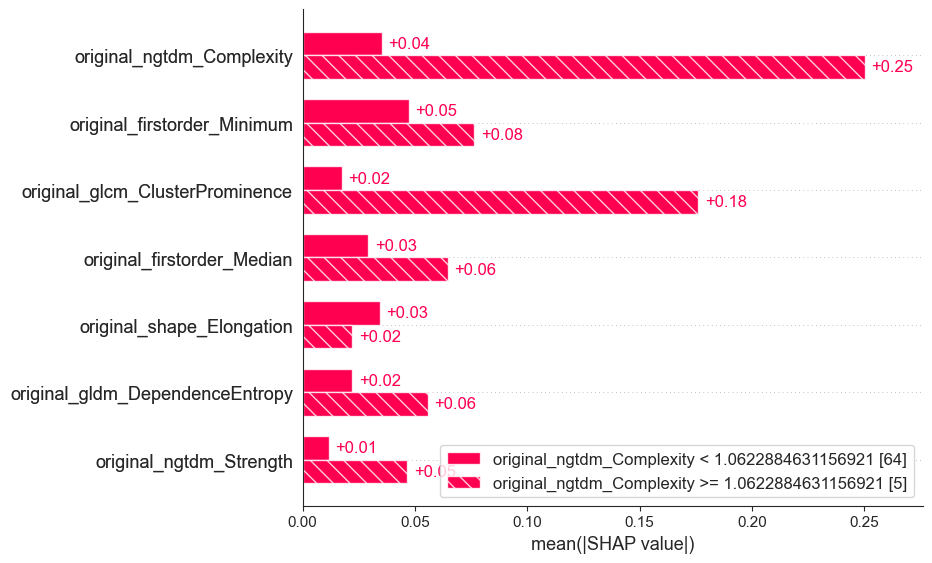

<font color=red>解读</font>

* ortginal_ngtdm_Complexity < 1.06 SHAP value 高;

* < 1.06的特征对模型预测值贡献大,对于该特征而言,小的特征值更容易增加模型预测贡献度;

* 临床角度,特征值较小可能与结局关联更大.

## <font color=darkblue>特征聚类</font>
```
通过模型损失比较来测量特征冗余;
条形图可视化特征冗余结构和特征重要性；
默认情况下，不会显示所有的聚类结构，而仅显示距离 < 0.5 的聚类部分；
假设聚类中的距离大致在 0 和 1 之间缩放，其中 0 距离表示特征完全冗余，1 表示特征完全独立。
```

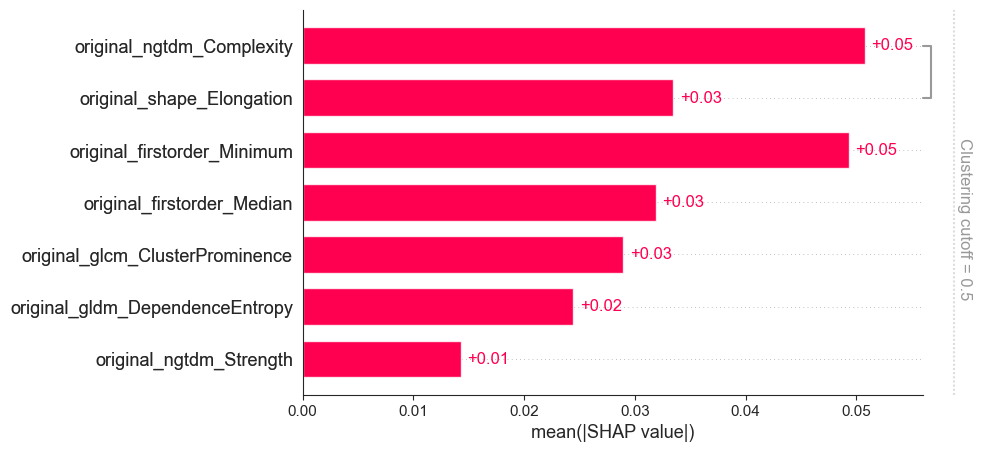

In [18]:
clustering = shap.utils.hclust(x_test, y_test_encoded)
# shreshold可以设置为0.5-0.9的区间
# shap.plots.bar(shap_values, clustering=clustering, cluster_threshold=0.9)
shap.plots.bar(shap_values, clustering=clustering)
plt.tight_layout()
plt.savefig('7.feature_cluster_plot.pdf', bbox_inches='tight', dpi=300)
plt.close()

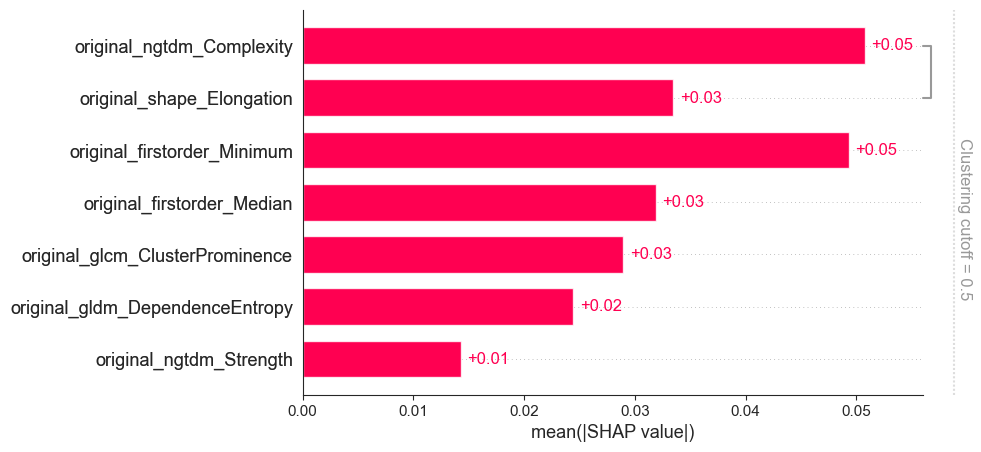

# 二、蜂群图

## <font color=darkblue>简单蜂群图</font>


<font color=red>SHAP最重要的可视化图之一</font>

显示数据集中的主要特征如何影响模型输出的信息密集摘要。

解读：Summary_plot 为每一个样本绘制其每个特征的Shapley value，它说明哪些特征最重要，以及它们对数据集的影响范围。Summary Plot是一个直观展示模型预测结果中每个特征贡献的图表。在这个图表中：

* Y轴：展示了各个特征

  每一个特征都有自己的一行，所有的特征都被排列在一起，便于查看和比较。

* X轴：展示了SHAP值

  SHAP值衡量了每个特征对模型预测的贡献大小。正值表示增加预测结果的可能性，负值表示减小预测结果的可能性。

* 点：代表单个样本

  图中的每个点代表数据集中一个样本的SHAP值。这意味着每个点都告诉我们对于这个特定的样本，这个特定的特征是如何影响模型输出的。

* 颜色：展示了特征值的大小

  点的颜色代表了特征的原始值。红色代表高值，蓝色代表低值。这种颜色编码帮助我们直观地看到特征的原始值与其对模型预测的影响之间的关系。

* 抖动：展示了SHAP值的分布

  由于有很多点可能落在相同的位置，为了更好地可视化分布，点会在Y轴方向上稍微抖动。这使我们能够看到每个特征的SHAP值是如何分布的，哪些值更常见。

* 排序：根据重要性排序

  特征按照它们对模型预测的平均影响（即SHAP值的绝对值的平均值）进行排序。这样，最重要的特征会出现在图表的顶部，最不重要的特征会出现在底部。

通过这种方式，Summary Plot提供了一种直观的方式来查看模型预测是如何由各个特征共同作用产生的，以及哪些特征对模型预测最有影响。这对于理解和解释复杂模型的预测至关重要。


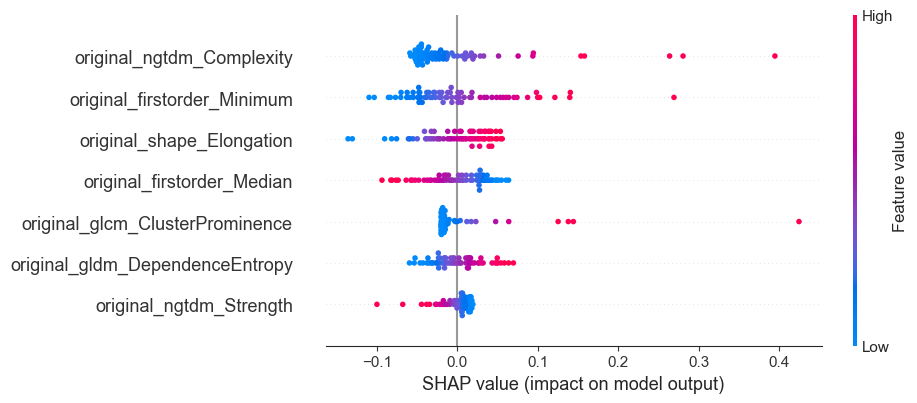

In [19]:
shap.plots.beeswarm(shap_values)
# shap.plots.beeswarm(shap_values, order=shap_values.abs.max(0))  # feature ordering
# shap.plots.beeswarm(shap_values, color=plt.get_cmap("cool"))    # change the color

plt.tight_layout()
plt.savefig('8.beeswarm_summary_plot.pdf')
plt.close()



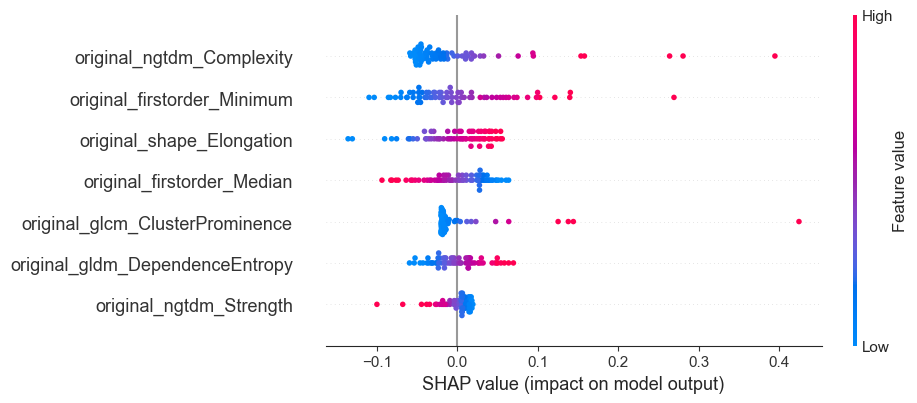


<font color=red>解读</font>

蜂群图（Beeswarm Plot）是另一种可视化全局特征重要性和影响的方法。蜂群图旨在显示数据集中的TOP特征如何影响模型输出的信息密集摘要。

* 给定解释的每个实例由每个特征流上的一个点表示；

* 点的 x 位置由该特征的 SHAP 值 ( shap_values.value[instance,feature]) 确定，并且点沿每个特征行“堆积”以显示密度；

* 颜色用于显示特征的原始值 ( shap_values.data[instance,feature])；

* 同样可以使用max_display参数调整最多显示行数；

* 默认使用每个特征的 SHAP 值的平均绝对值shap_values.abs.mean(0) 对特征排序；

* 然而，这个顺序更强调广泛的平均影响，而不是罕见但高强度的影响。

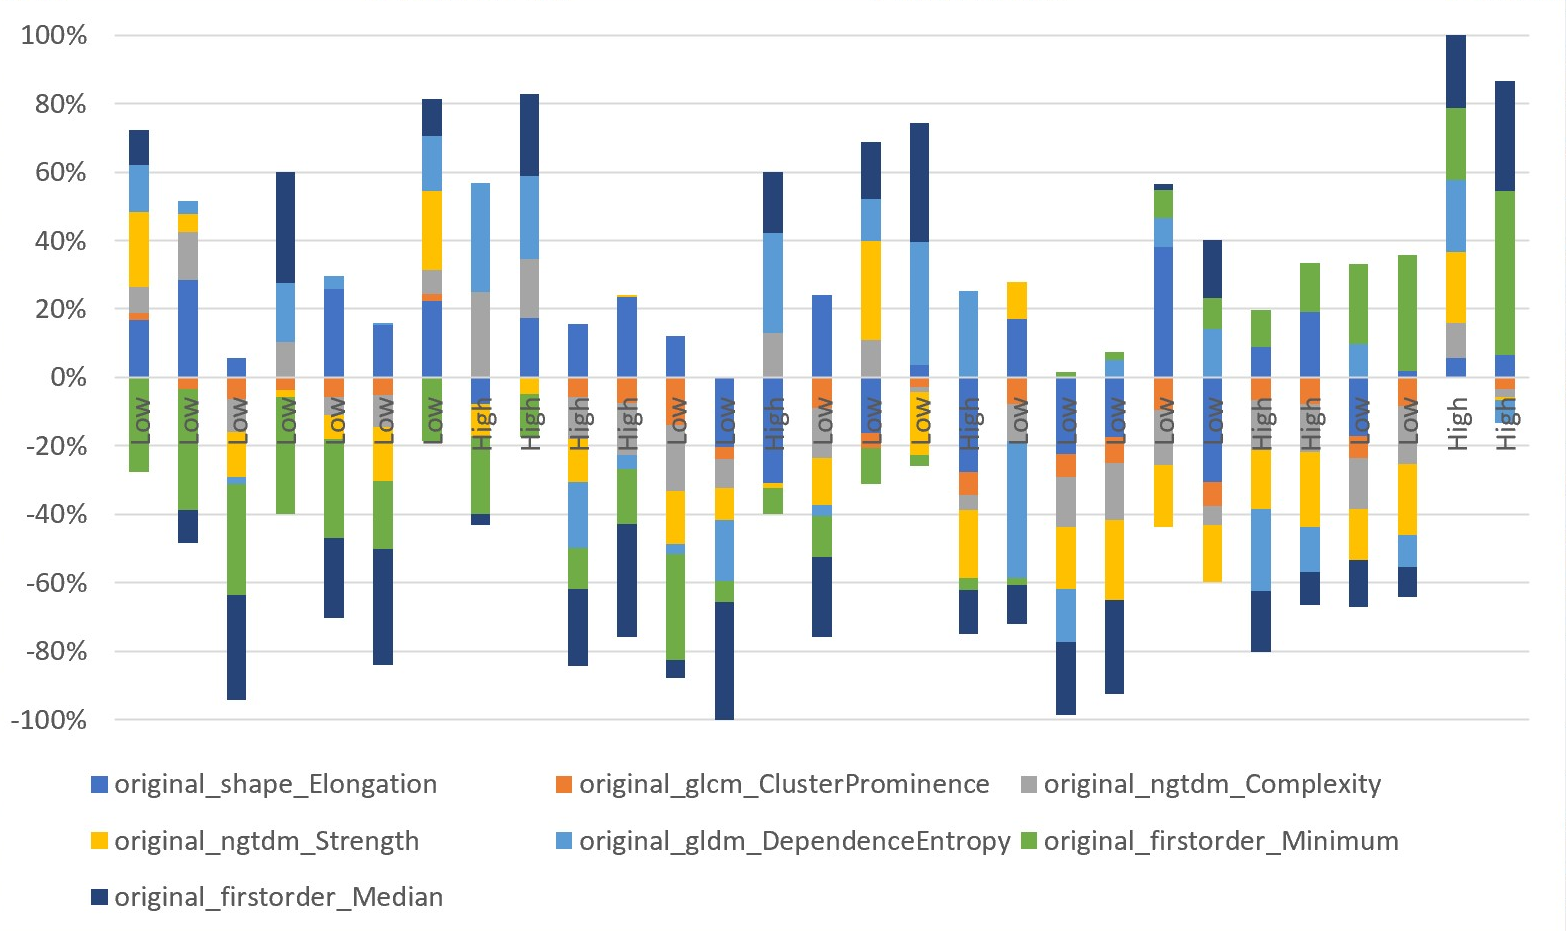

<font color=red>解读</font>

根据本图(模型特征值的cel可视化),可以粗浅对比出特征变化对模型全局预测效果的影响;

## <font color=darkblue>条形图 vs 蜂群图</font>
```
全局条形图只展示了蜂群图的平均值，
而蜂群图可以展示全局并展示内部个体的分布。
```

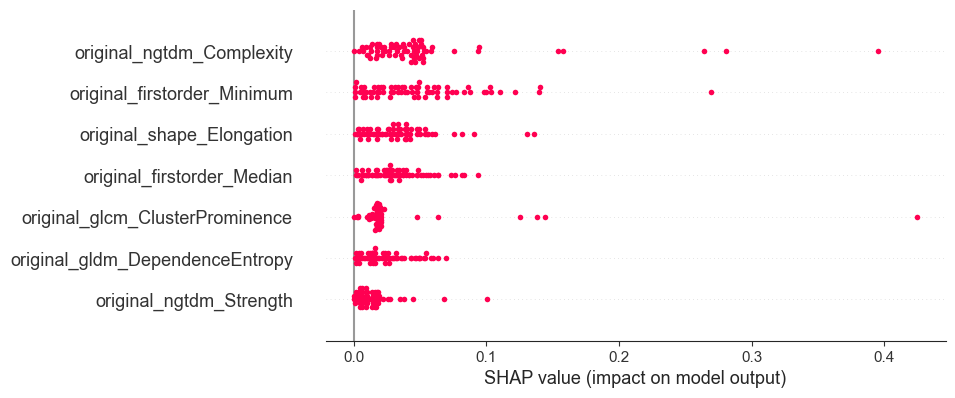

In [20]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

plt.tight_layout()
plt.savefig('9.plot_vs_beeswarm_bee.pdf')
plt.close()

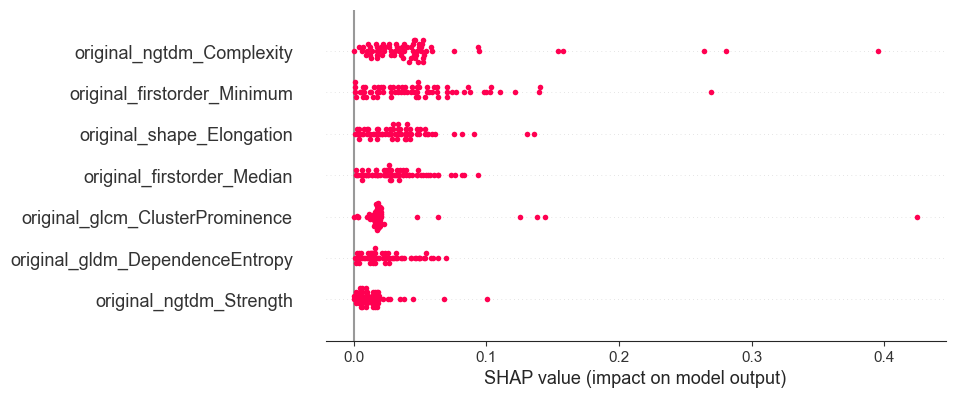

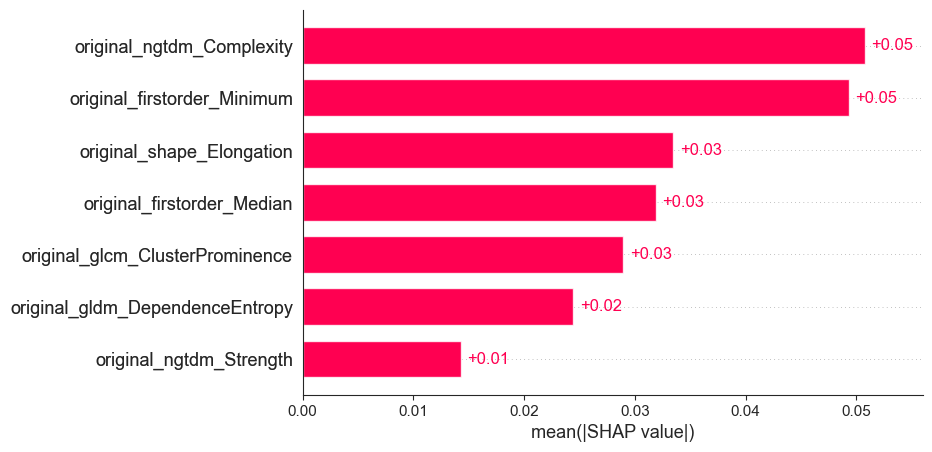

In [21]:
shap.plots.bar(shap_values.abs.mean(0))

plt.tight_layout()
plt.savefig('10.plot_vs_beeswarm_plot.pdf')
plt.close()

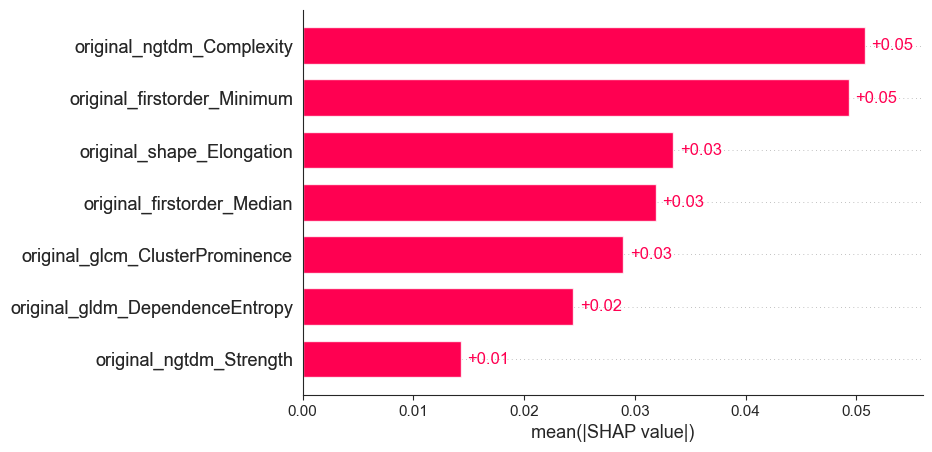

# 三、依赖图

依赖图（Partial dependence plot ）可以帮助我们理解单个特征如何影响模型的预测。它揭示了一个或两个特征如何影响模型的预测结果。这个图不仅能显示特征与目标之间是否存在线性、单调或更复杂的关系，还能在众多样本中展示特征值和其对应的SHAP值之间的关系。

* 全局视角: 依赖图为我们提供了一个全局的视角，考虑了所有的样本来展示特征和预测结果之间的关系。

* 假设检验: 它基于一个重要的假设——正在考察的两个特征是相互独立的。如果这个假设不成立，那么计算得到的平均影响可能会包含一些不太可能或不可能出现的数据点。


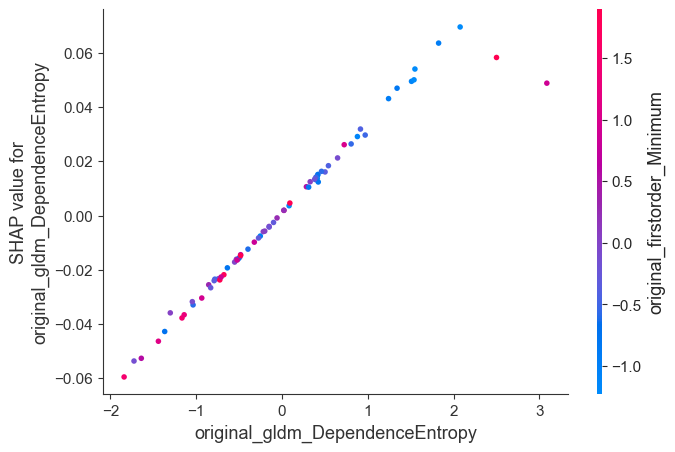

In [22]:
# 逐个特征尝试,都很差换测试集试试
shap_values_array = shap_values.values  # 获取SHAP值的数组
shap.dependence_plot('original_gldm_DependenceEntropy', shap_values_array, x_train)
plt.tight_layout()
plt.savefig('11.dependence_plot_original_gldm_DependenceEntropy.pdf')
plt.close()



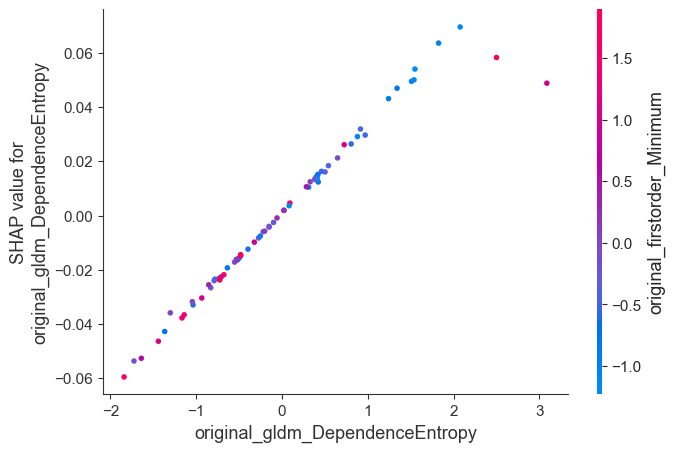

<font color=red>解读</font>

Dependence plot 是一个散点图，显示单个特征对整个数据集的影响。

* 每个点都是来自数据集的单个预测（行）；

* x 轴是数据集中的实际值。（来自 X 矩阵，存储在 中shap_values.data）；

* y 轴是该特征的 SHAP 值（存储在 中shap_values.values），它表示该特征值对该预测的模型输出的改变程度；

* 颜色通常用来表示另一个特征的值，以展示当前正在查看的特征与另一个特征之间的可能交互作用；

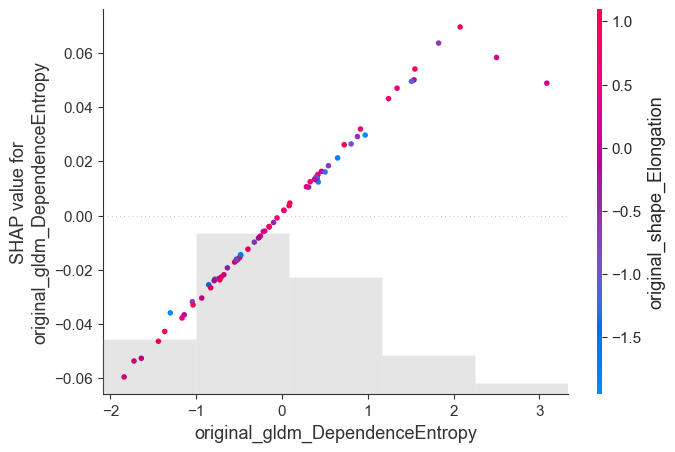

In [23]:
# 散点图方法绘制依赖图;
shap.plots.scatter(shap_values[:, "original_gldm_DependenceEntropy"], 
                   color=shap_values[:,"original_shape_Elongation"])

plt.tight_layout()
plt.savefig('12.scatter_plot_original_gldm_DependenceEntropy.pdf')
plt.close()

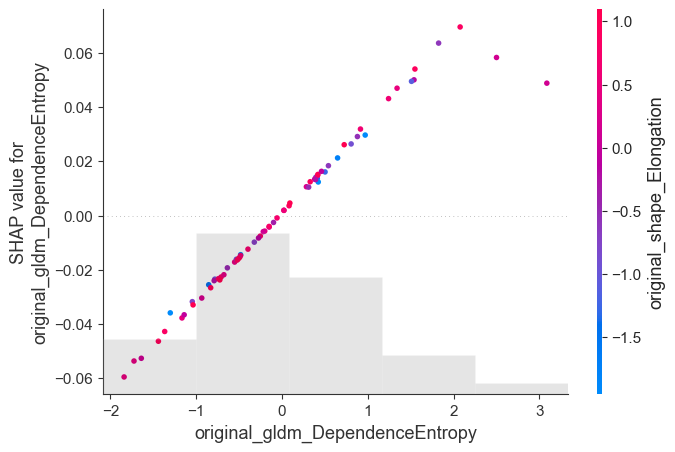

<font color=red>解读</font>

底部的浅灰色区域是显示数据值分布的直方图;

交互颜色: dependence_plot 默认而散点图则需要将整个 Explanation 对象传递给 color 参数.

# 四、SHAP 热图

```
热图显示了一个数据集的整体子结构，其中样本和特征都通过它们的 shap values 进行聚类排序，以便显示出数据的内在结构。
```

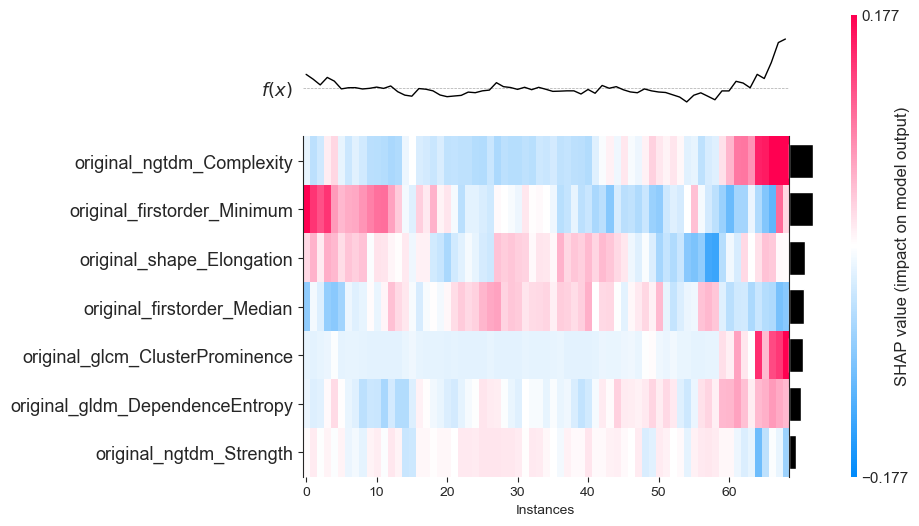

In [24]:
# 按平均绝对shap值排序
shap.plots.heatmap(shap_values)

plt.tight_layout()
plt.savefig('13.heatmap_mean_plot.pdf',bbox_inches='tight', dpi=300)
plt.close()

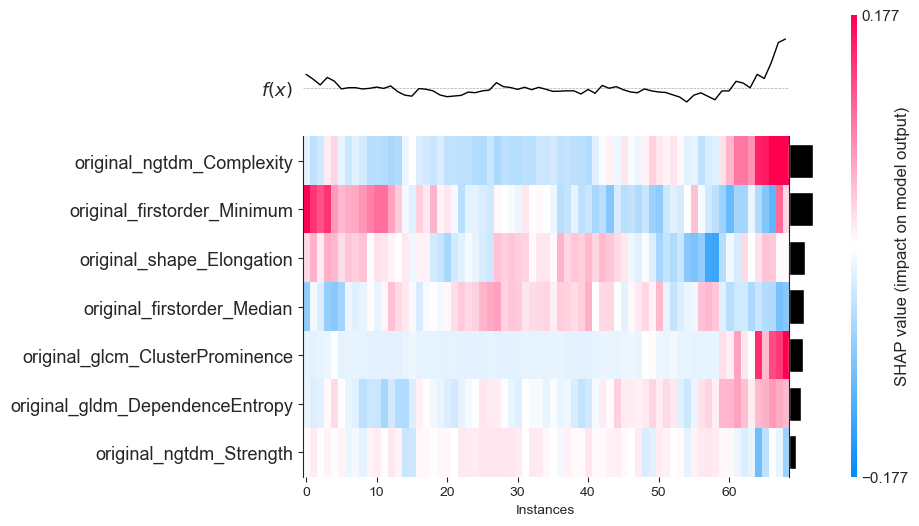

<font color=red>解读</font>

* 热图每一列代表一个样本,每一行代表一个特征,颜色代表特征的SHAP值。

* 红色区域：意味着这些特征的值在这些特定样本上增加了模型输出结果为正类的可能性。

* 蓝色区域：意味着这些特征的值在这些特定样本上降低了模型输出结果为正类的可能性。

* 默认情况下，样本使用 shap.order.hclust 排序，它基于层次聚类并根据解释相似性对样本进行排序。将因相同原因和具有相同模型输出的样本被分组在一起。

* f(x)是输出值, 模型的预测概率,曲线高点表示模型输出为正类的概率高。

* 在热图矩阵上方是模型的输出，灰色虚线是基线(.base_value），图右侧的条形图是每个模型输入的全局重要性（默认用shap.order.abs.mean整体重要性来度量）。

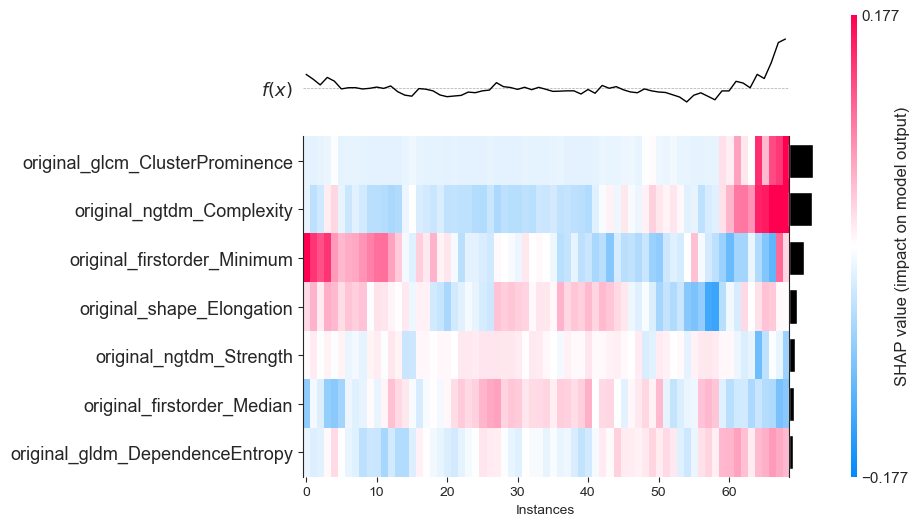

In [25]:
# 按最大绝对shap值排序
shap.plots.heatmap(shap_values, feature_values=shap_values.abs.max(0))

plt.tight_layout()
plt.savefig('14.heatmap_max_plot.pdf',bbox_inches='tight', dpi=300)
plt.close()

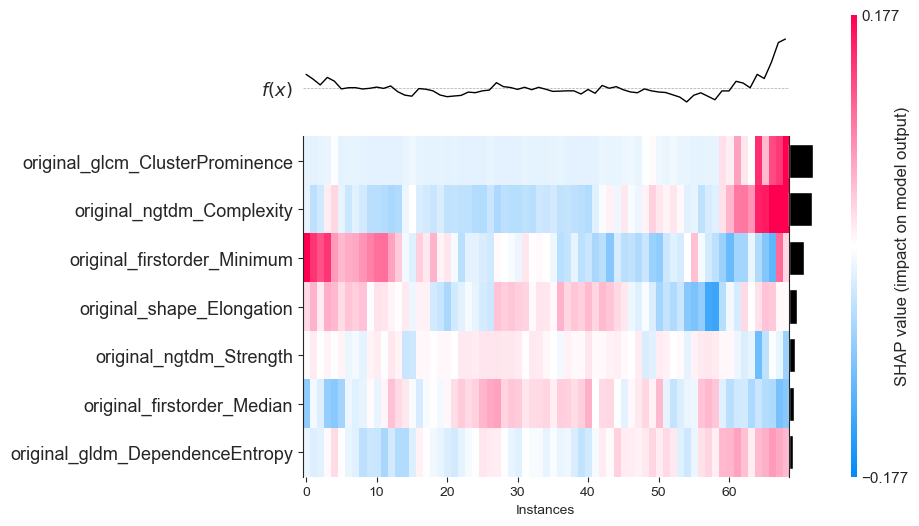

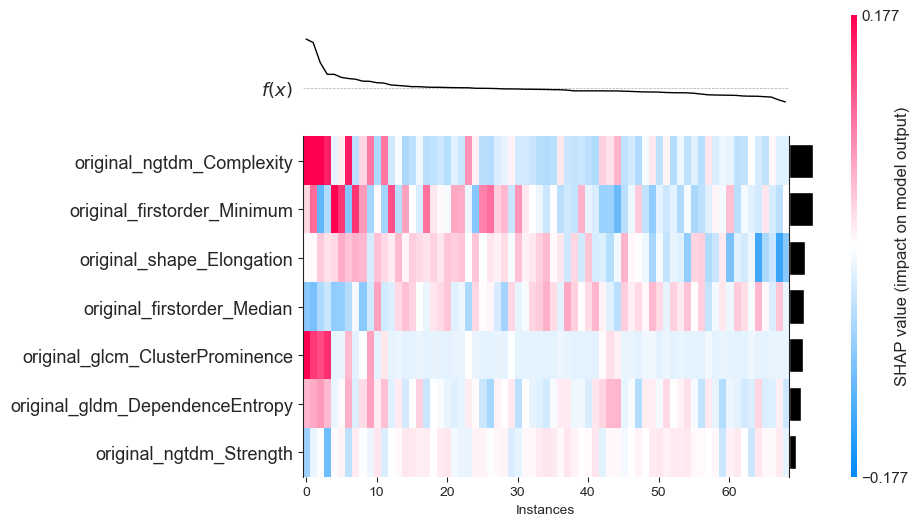

In [26]:
# 将样本按照它们对模型预测的总体影响排序
# 通过给instance_order参数传递一组值控制实例的顺序。将具有相似解释的样本分组在一起。

shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1))

plt.tight_layout()
plt.savefig('15.heatmap_effect_plot.pdf',bbox_inches='tight', dpi=300)
plt.close()

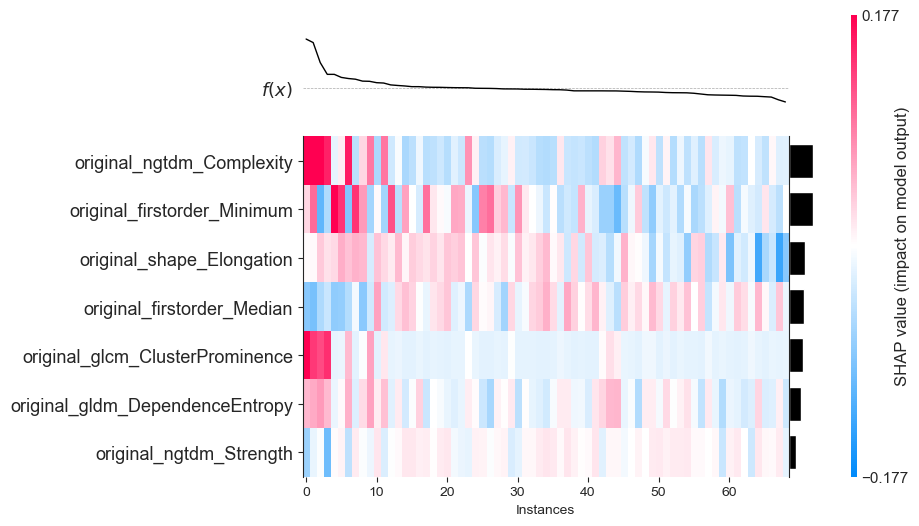

# 五、瀑布图
```
瀑布图（Waterfall Plot）是用来显示单个预测的 SHAP 值的。瀑布图从底部的模型输出的预期值开始，每一行显示每个特征的是正（红色）或负（蓝色）贡献，即如何将值从数据集上的模型预期输出值推动到模型预测的输出值。
```

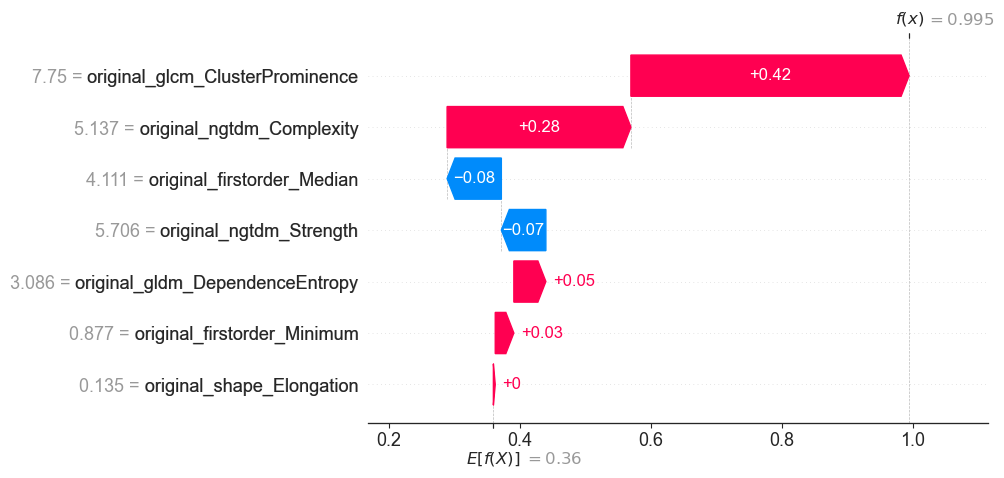

In [27]:
shap.plots.waterfall(shap_values[65])  # 选择需要输出样本的瀑布图

plt.tight_layout()
plt.savefig('16.waterfall_plot.pdf',bbox_inches='tight', dpi=300)
plt.close()

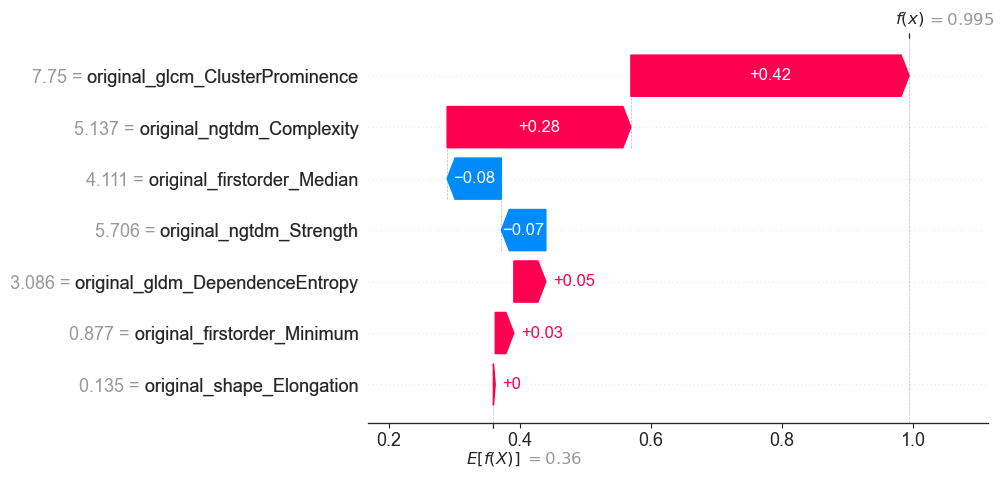

<font color=red>解读</font>

* E[f(x)] 模型对所有数据的平均预测值;

* 每个条形表示一个特征对预测值的贡献。红色条形表示该特征使预测值增加（对预测正类的概率有正面影响），蓝色条形表示该特征使预测值减少（对预测正类的概率有负面影响）。

*  预测值f(x)，对于个体的基线值加上所有特征贡献之和。对于分类问题，这可能是预测为正类的概率。

# 六、力图
```
Force Plot用于展示单个预测的SHAP值，帮助我们理解每个特征是如何影响模型输出的，实现单个预测的解释可视化。
```

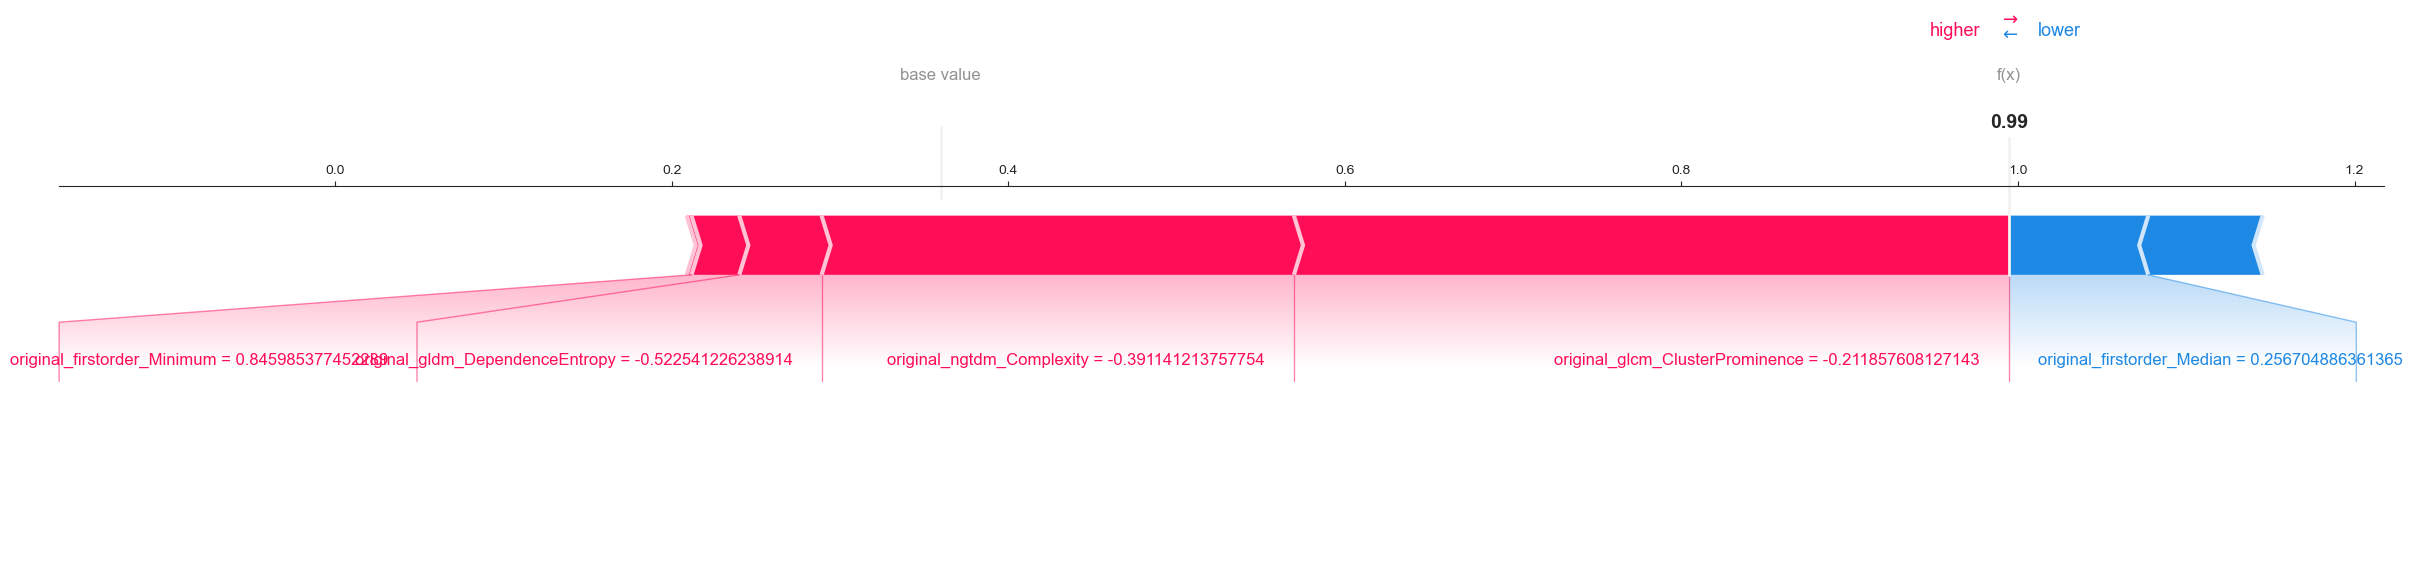

In [28]:
# 生成单个样本的力图
shap.force_plot(
        base_value=explainer.expected_value,  # 预期值
        shap_values=shap_values.values[65],    # 第65个样本的 SHAP 值
        features=x_train.iloc[0, :],           # 第65个样本的特征值
        matplotlib=True,
        figsize=(30, 5)
)


plt.tight_layout()
plt.subplots_adjust(left=0.8, right=0.9, top=0.9, bottom=0.1)

plt.savefig('17.force_plot.pdf',bbox_inches='tight', dpi=300)
plt.close()

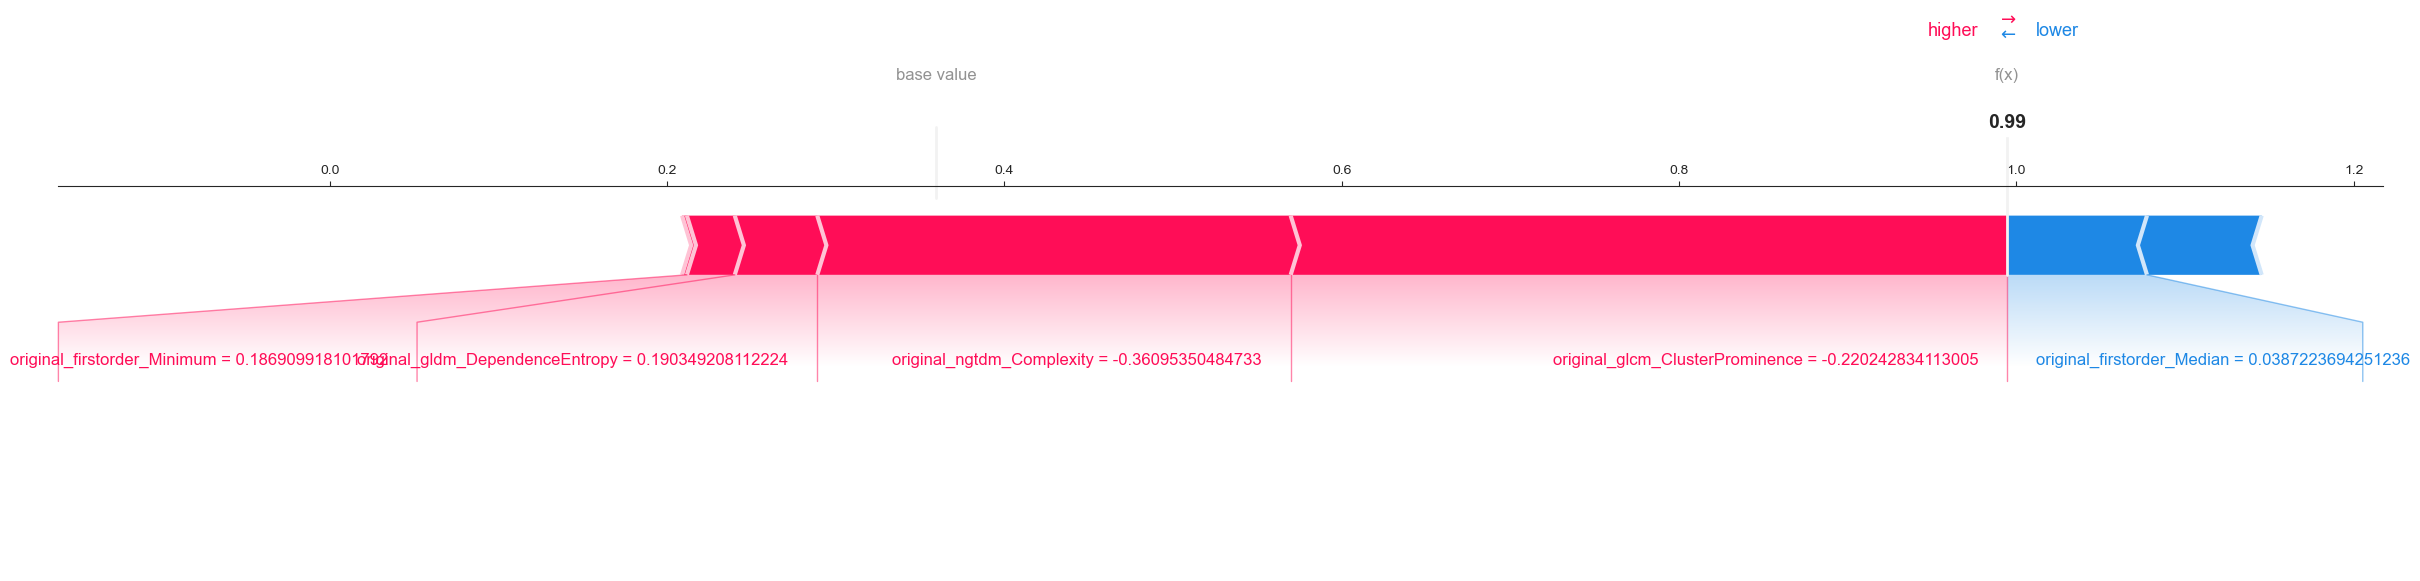

<font color=red>解读</font>

* 模型输出值：0.99

* 基值：模型输出与训练数据的平均值（explainer.expected_value）

* 绘图箭头下方数字是此实例的特征值

* 将预测推高的特征用红色表示，将预测推低的特征用蓝色表示

* 箭头越长，特征对输出的影响越大。通过 x 轴上刻度值可以看到影响的减少或增加量。

In [29]:
# 生成多个样本的力图
# 多个样本进行解释，单个样本力图旋转90度然后水平并排放置，得到力图的变体
force_plot_html = shap.force_plot(
    explainer.expected_value,        # 预期值
    shap_values.values[:100],        # 前100个样本的 SHAP 值
    x_train.iloc[:100, :],            # 前100个样本的特征值
    matplotlib=False                 # 使用交互式图表
)

shap.save_html('18.multi_force_plot.html', force_plot_html)  # 保存为 HTML 文件

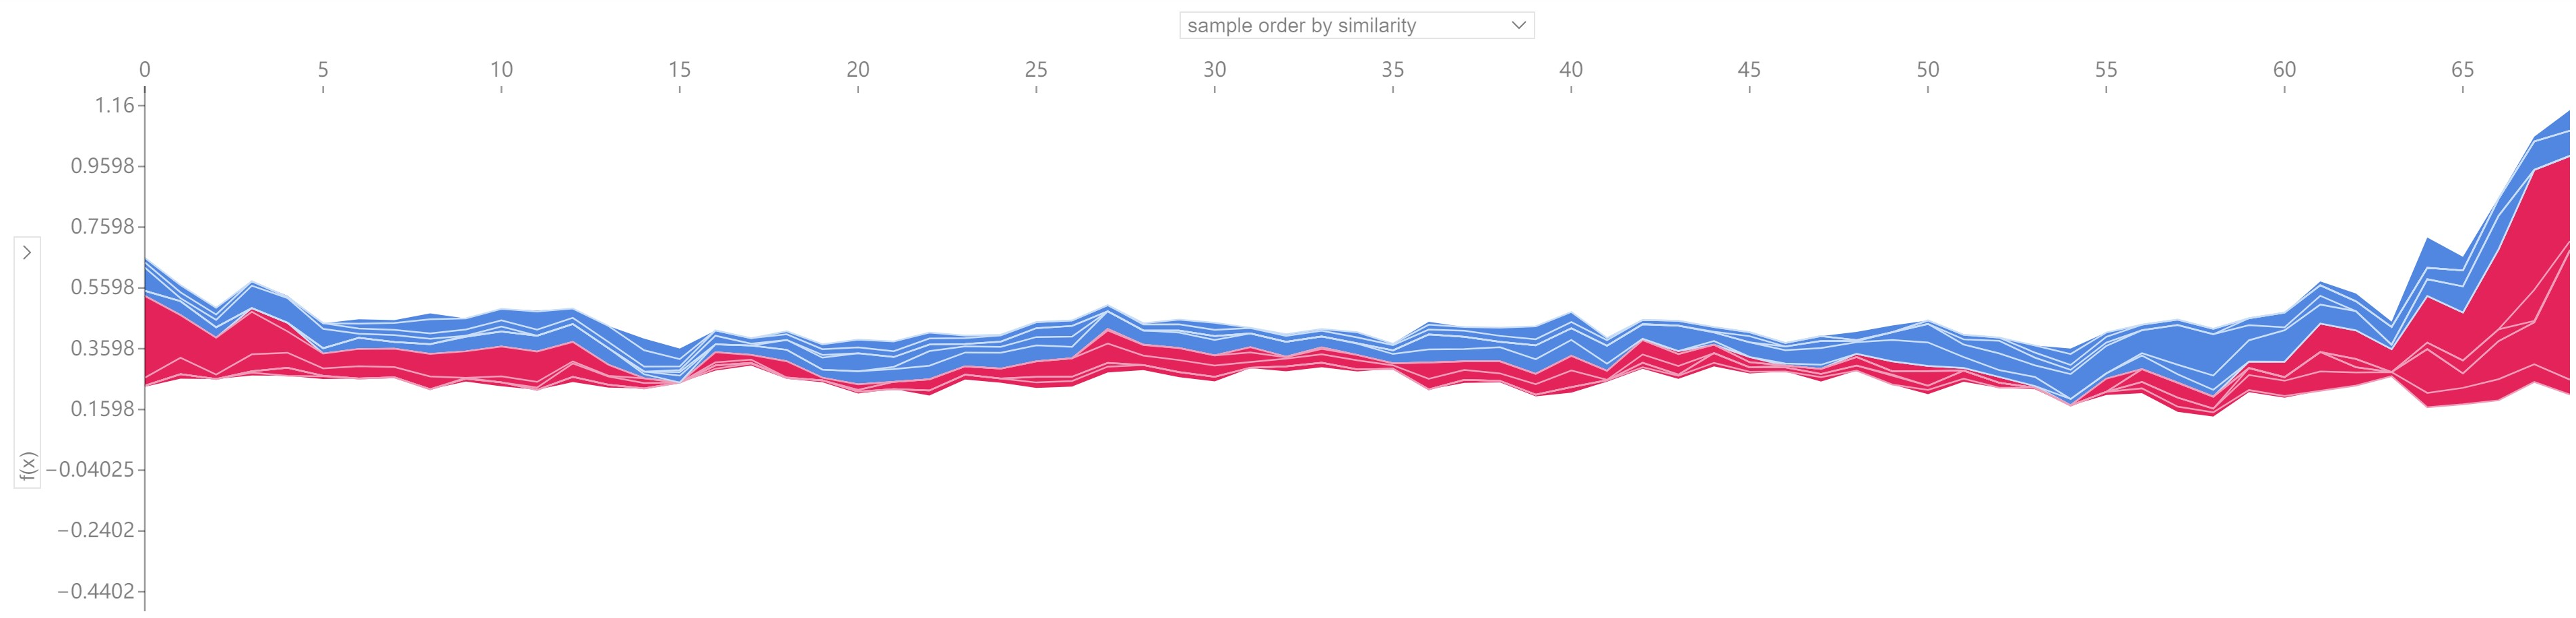


<font color=red>解读</font>

* X轴：通常代表样本的索引，按某种相似性排序（可能是模型输出值或特定特征的SHAP值）。

* Y轴：显示了SHAP值，即每个特征对模型预测的影响程度。正值表示特征对模型预测的增加作用，负值表示减少作用。

* 颜色：通常区分正负影响或不同的特征组。

* 识别识别对模型贡献最大的特征。

# 七、决策图

```
SHAP 决策图显示复杂模型如何得出其预测（即模型如何做出决策）。决策图是 SHAP value 的文字表示，使其易于解读。

决策图显示的信息与力图基本相同，都可以有效地解释上述模型的预测。而且很容易识别出主要影响的大小和方向。

决策图比力图更清晰和直观，尤其是要分析的特征比较多的时候。在力图中，当预测变量的数量较多时，信息可能看起来非常紧凑。
```

In [43]:
# 第65个样本shap_values_decision 
shap_values_decision = explainer.shap_values(x_train)[65]

  0%|          | 0/69 [00:00<?, ?it/s]

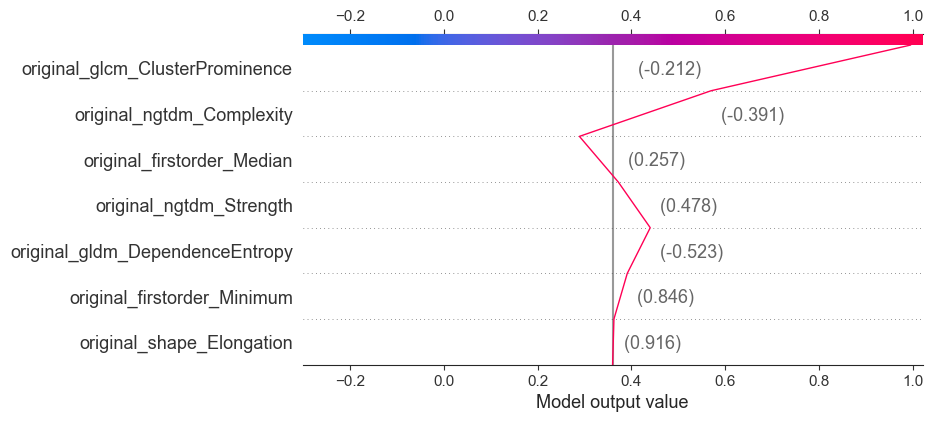

In [44]:
shap.decision_plot(expected_value, shap_values_decision, x_train)

plt.tight_layout()
plt.savefig('19.decision_plot.pdf',bbox_inches='tight', dpi=300)
plt.close()

<font color=red>解读</font>

* 灰色垂直线：标记了模型的基础值。

* 彩色线：表示每个特征是否将输出值推向高于或低于平均预测的值。

* 特征值：在预测线旁边显示。

* 从图的底部开始，预测线显示 SHAP value 如何从基础值累积到图顶部的模型最终分数。

In [46]:
# 所有样本的全局决策图
shap_values_decision = explainer.shap_values(x_train)

  0%|          | 0/69 [00:00<?, ?it/s]

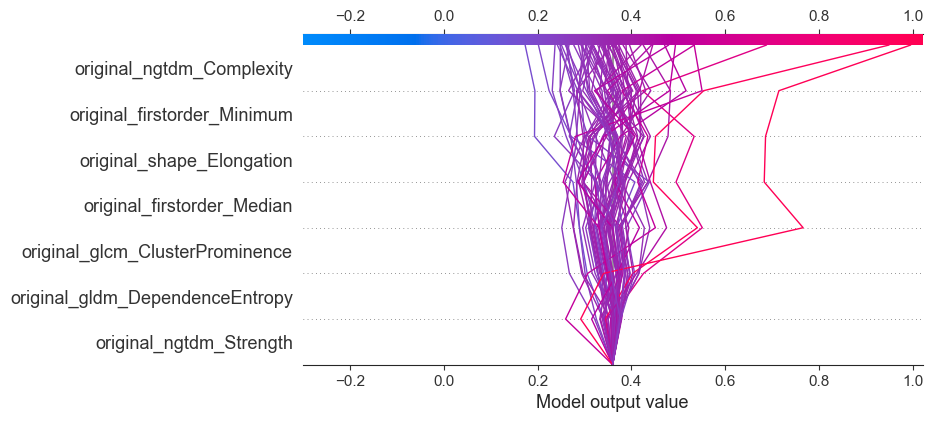

In [47]:
shap.decision_plot(expected_value, shap_values_decision, x_train)

plt.tight_layout()
plt.savefig('20.summary_decition_plot.pdf',bbox_inches='tight', dpi=300)
plt.close()